In [1]:
import vit
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchsummary

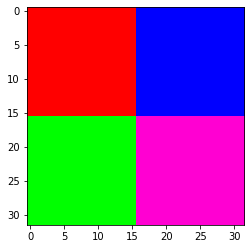

In [15]:
img = torch.zeros((1, 3, 32, 32))
img[:, 0, :16, :16] = 1 # oben links rot
img[:, 1, 16:, : 16] = 1 # unten links grün
img[:, 2, :16, 16:] = 1

img[:, 0, 16:, 16:] = 1
img[:, 2, 16:, 16:] = 210 / 255

plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())

torch.Size([1, 16, 192])


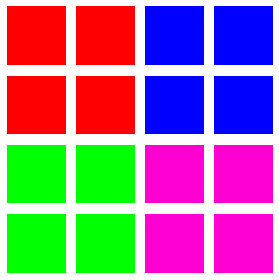

In [10]:
patches = vit._image_to_patches(img, 8)
print(patches.shape)
vit.show_patches(patches, 3, 8)

torch.Size([1, 4, 4, 8, 8, 3])


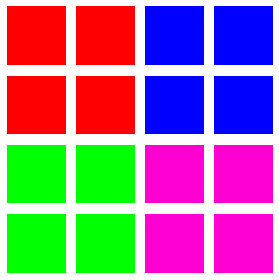

In [12]:
out = img.unfold(2, 8, 8).unfold(3, 8, 8).permute(0,2,3,4,5,1)
print(out.shape)
out = out.reshape(img.size(0), 4**2 ,-1)
vit.show_patches(out, 3, 8)

In [29]:
own_vit = vit.VisionTransformer(64, 32, 8, 3, 2, 64, 1, 10)
torchsummary.summary(own_vit, (16, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 64]          12,288
           Dropout-2               [-1, 17, 64]               0
         LayerNorm-3               [-1, 17, 64]             128
            Linear-4               [-1, 17, 64]           4,096
            Linear-5               [-1, 17, 64]           4,096
            Linear-6               [-1, 17, 64]           4,096
           Softmax-7            [-1, 2, 17, 17]               0
           Dropout-8            [-1, 2, 17, 17]               0
ScaledDotProductAttention-9            [-1, 2, 17, 32]               0
           Linear-10               [-1, 17, 64]           4,160
MultiHeadAttention-11               [-1, 17, 64]               0
          Dropout-12               [-1, 17, 64]               0
        LayerNorm-13               [-1, 17, 64]             128
           Linear-14           

In [38]:
from torchvision.models.vision_transformer import VisionTransformer

torch_vit = VisionTransformer(
    32, 8, 1, 2, 64, 64, 0.0, 0.0, 10
)
torch_vit(torch.randn((1, 3, 32, 32)))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward0>)

In [2]:
from vit_github import ViT

github_vit = ViT(mlp_hidden=384, patch_size=4)
p = torch.load('github_impls/ViT-CIFAR/weights/vit_c10_aa_ls.pth', map_location='cpu')
github_vit.load_state_dict({k[6:]: p[k] for k in p})

/tmp/ipykernel_220096/4057277040.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  p = torch.load('github_impls/ViT-CIFAR/weights/vit_c10_aa_ls.pth', map_location='cpu')


<All keys matched successfully>

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2

transform = v2.Compose((
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
))

val_loader = DataLoader(datasets.CIFAR10('data', train=False, transform=transform), batch_size=1024)

In [4]:
device = torch.device('cuda:0')
github_vit.to(device)
correct = 0
total = 0
entropy_sum = 0

with torch.no_grad():
    for input, target in val_loader:
        input = input.to(device)
        target = target.to(device)

        logits = github_vit(input)
        predicted = logits.argmax(dim=-1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        entropy_sum += torch.distributions.Categorical(logits=logits).entropy().sum().item()
    train_accuracy = correct / total
    train_entropy = entropy_sum / total

print(f'Accuracy: {train_accuracy}')
print(f'Entropy: {train_entropy}')

Accuracy: 0.6975
Entropy: 1.30594736328125
